In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## **TWIITER TEXT ENGINE**

Create your own search engine or classifier using the tweets in the dataset. The steps you should do are:


1.   Perform text cleaning.
2.   Apply some clustering to check distributions of tweets.
3.   Create your own text search engine or tweets classifier using the provided labels

As features you can use BoW, TF-IDF and Word2Vec algorithms to compare results.

In [90]:
import pandas as pd
import os 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import re
import random

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import Word2Vec
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score

import nltk
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
path_to_genre = os.path.join(os.path.sep,'content','gdrive','My Drive','Colab Notebooks','LSMA', '4 - Text_Analysis-1')

tweets_path = '/content/gdrive/My Drive/Colab Notebooks/LSMA/4 - Text_Analysis-1/tweets.csv'
tweets = pd.read_csv(tweets_path)

In [4]:
tweets.head(10)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada)
6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada)
7,570300248553349120,neutral,0.6340,NaN,NaN,Virgin America,NaN,pilot,NaN,0,@VirginAmerica Really missed a prime opportuni...,NaN,2015-02-24 11:12:29 -0800,Los Angeles,Pacific Time (US & Canada)
8,570299953286942721,positive,0.6559,NaN,NaN,Virgin America,NaN,dhepburn,NaN,0,"@virginamerica Well, I didn't…but NOW I DO! :-D",NaN,2015-02-24 11:11:19 -0800,San Diego,Pacific Time (US & Canada)
9,570295459631263746,positive,1.0000,NaN,NaN,Virgin America,NaN,YupitsTate,NaN,0,"@VirginAmerica it was amazing, and arrived an ...",NaN,2015-02-24 10:53:27 -0800,Los Angeles,Eastern Time (US & Canada)


In [5]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

We can remove the airline_Sentiment_gold and the negativereason_olg, since there are many missing values, as well as other columns that are no relevant.


In [0]:
tweets = tweets.drop(['airline_sentiment_gold','negativereason_gold','tweet_coord', 'tweet_created', 'tweet_location', 'retweet_count', 'user_timezone','negativereason_confidence'], axis=1)

In [7]:
tweets.tail()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,airline,name,text
14635,569587686496825344,positive,0.3487,NaN,American,KristenReenders,@AmericanAir thank you we got on a different f...
14636,569587371693355008,negative,1.0000,Customer Service Issue,American,itsropes,@AmericanAir leaving over 20 minutes Late Flig...
14637,569587242672398336,neutral,1.0000,NaN,American,sanyabun,@AmericanAir Please bring American Airlines to...
14638,569587188687634433,negative,1.0000,Customer Service Issue,American,SraJackson,"@AmericanAir you have my money, you change my ..."
14639,569587140490866689,neutral,0.6771,NaN,American,daviddtwu,@AmericanAir we have 8 ppl so we need 2 know h...


In [8]:
tweets['text'][12]

"@VirginAmerica This is such a great deal! Already thinking about my 2nd trip to @Australia &amp; I haven't even gone on my 1st trip yet! ;p"

## **EDA**

We are going to do some exploratory analysis, to see how many tweets are neutral, positive or negative, the number of positive or negative tweets each airline receives, and also which type of negative comments the airline receive. 

In [9]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   airline                       14640 non-null  object 
 5   name                          14640 non-null  object 
 6   text                          14640 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 800.8+ KB


Text(0.5, 1.0, 'Count of Moods')

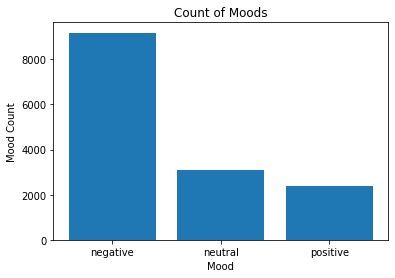

In [10]:
index = [1, 2, 3]
sentiment = tweets['airline_sentiment'].value_counts()

plt.bar(index, sentiment)
plt.xticks(index,['negative','neutral','positive'])
plt.ylabel('Mood Count')
plt.xlabel('Mood')
plt.title('Count of Moods')

As always, there is much more negative feedback than positive or neutral, therefore the data is no quite balanced.

In [11]:
tweets.groupby(['airline_sentiment', 'airline'], as_index=False).count()

,airline_sentiment,airline,tweet_id,airline_sentiment_confidence,negativereason,name,text
0,negative,American,1960,1960,1960,1960,1960
1,negative,Delta,955,955,955,955,955
2,negative,Southwest,1186,1186,1186,1186,1186
3,negative,US Airways,2263,2263,2263,2263,2263
4,negative,United,2633,2633,2633,2633,2633
5,negative,Virgin America,181,181,181,181,181
6,neutral,American,463,463,0,463,463
7,neutral,Delta,723,723,0,723,723
8,neutral,Southwest,664,664,0,664,664
9,neutral,US Airways,381,381,0,381,381


Lets see this in a graph to understand more clearly how the user feel about each airline. 

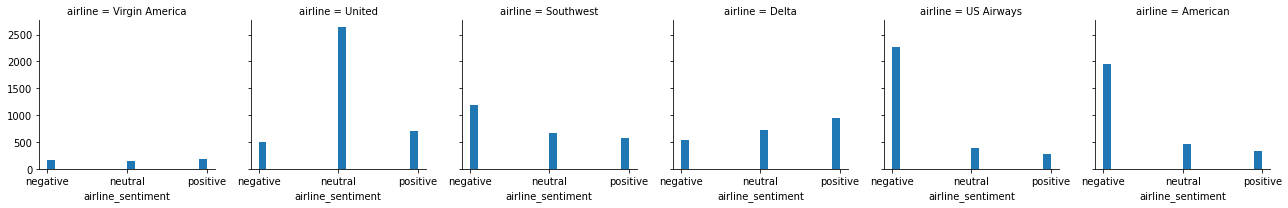

In [12]:
g = sns.FacetGrid(tweets, col='airline')
g.map(plt.hist, 'airline_sentiment', bins=20)

Virginia:


*   Less opinions
*   Balance results

United: 


*   Low number of positive and negative opinions (balanced)
*   High number of neutral opinions

Southwest: 


*   Average number of opinions 
*   More negrative opinions, but overall balanced

Delta: 


*   Average number of opinions 
*   More positive opinions, but overall balanced

US Airways:


*   Low number of positive and neutral opinions (balanced)
*   High number of negative opinions

American:

*   Low number of positive and neutral opinions (balanced)
*   High number of negative opinions


1.   MOST POSITIVELY RATED: DELTA
2.   MOST NEGATIVELY RATED: US AIRWAYS AND AMERICAN 
3.   MOST NEUTRALLY RATED: UNITED













In [13]:
tweets.groupby(['airline_sentiment', 'negativereason'], as_index=False).count()

,airline_sentiment,negativereason,tweet_id,airline_sentiment_confidence,airline,name,text
0,negative,Bad Flight,580,580,580,580,580
1,negative,Can't Tell,1190,1190,1190,1190,1190
2,negative,Cancelled Flight,847,847,847,847,847
3,negative,Customer Service Issue,2910,2910,2910,2910,2910
4,negative,Damaged Luggage,74,74,74,74,74
5,negative,Flight Attendant Complaints,481,481,481,481,481
6,negative,Flight Booking Problems,529,529,529,529,529
7,negative,Late Flight,1665,1665,1665,1665,1665
8,negative,Lost Luggage,724,724,724,724,724
9,negative,longlines,178,178,178,178,178


The top 3 most common issues are: 

1.   Customer Service Issue
2.   Late flight
3.   Can't tell 





In [14]:
tweets.groupby([ 'negativereason','airline'], as_index=False).count().sort_values(by='airline', ascending=False)

,negativereason,airline,tweet_id,airline_sentiment,airline_sentiment_confidence,name,text
59,longlines,Virgin America,3,3,3,3,3
17,Cancelled Flight,Virgin America,18,18,18,18,18
35,Flight Attendant Complaints,Virgin America,5,5,5,5,5
29,Damaged Luggage,Virgin America,4,4,4,4,4
5,Bad Flight,Virgin America,19,19,19,19,19
23,Customer Service Issue,Virgin America,60,60,60,60,60
47,Late Flight,Virgin America,17,17,17,17,17
41,Flight Booking Problems,Virgin America,28,28,28,28,28
11,Can't Tell,Virgin America,22,22,22,22,22
53,Lost Luggage,Virgin America,5,5,5,5,5


We will plot this info, in order to see the reasons for the bad reputation. 

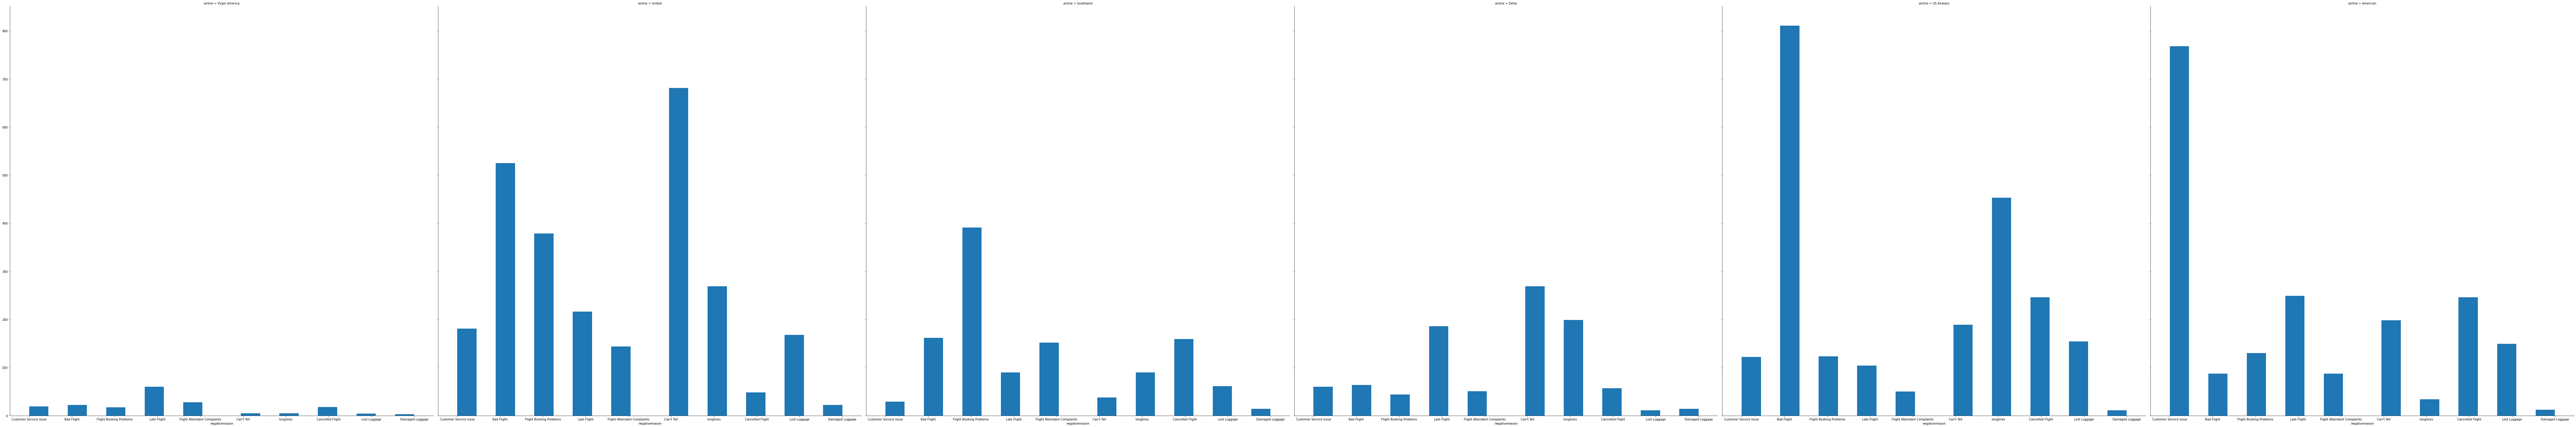

In [15]:
g = sns.FacetGrid(tweets, col='airline')

fig = plt.gcf()
fig.set_size_inches(120, 20)

g.map(plt.hist, 'negativereason', bins=20)
#g.fig.set_figwidth(100)
#g.fig.set_figheight(10)

The main reasons per airline are the following: 

Virginia:


*   Customer service Issue 
*   Flight booking problem

United: 


*   Customer service Issue  
*   Late flight

Southwest: 


*   Customer service Issue 
*   Flight cancelled

Delta: 


*   Customer service Issue  
*   Late flight

US Airways:


*   Customer service Issue  
*   Late flight

American:

*   Customer service Issue  
*   Late flight


Lets visualize the most common words. 

In [0]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [0]:
neg_reason = tweets['negativereason'].dropna()
neg_reason = pd.DataFrame(neg_reason)

In [18]:
neg_reason.head()

,negativereason
3,Bad Flight
4,Can't Tell
5,Can't Tell
15,Late Flight
17,Bad Flight


In [0]:
words = ' '.join(neg_reason['negativereason'])

In [20]:
type(words)

str

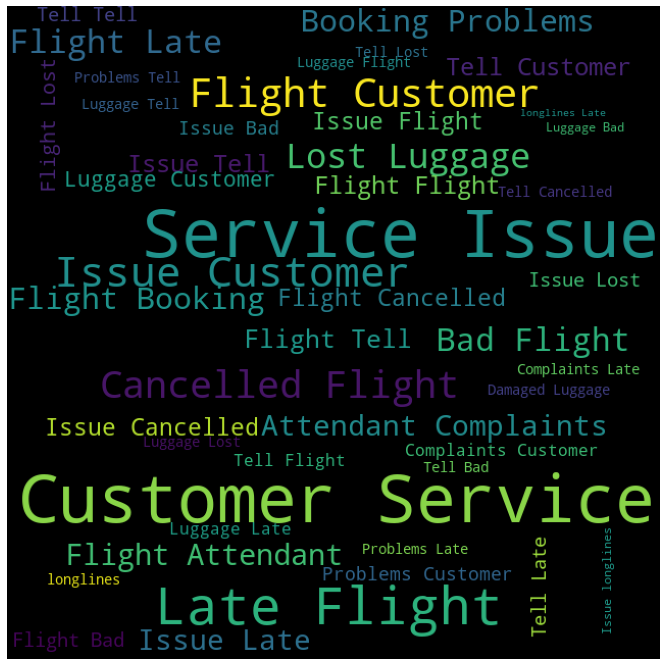

In [21]:
# Create the wordcloud object
wordcloud = WordCloud(width=640, height=640, margin=0).generate(words)
 
# Display the generated image:
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

It makes sense that Customer Service, Late flight, and Service Issue are the one standing out, since we have seen that they are the most common. 

Now we are going to proceed to clean our tweets, so that we can then use that text for clustering.

## **Cleaning text**

In [0]:
text_in_tweets = tweets['text']

In [23]:
type(text_in_tweets)

pandas.core.series.Series

In [24]:
print(type(text_in_tweets[0]))

<class 'str'>


We are going to use the pipeline the teacher provide us, and create a list of list, with the clean words per tweet. 

In [0]:
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords
import re

final_cleaned_words = []

for index, tweet in text_in_tweets.items():
  #print(index)  
  #print(type(value))  
  tweet_without_username = re.sub(r'^@\w+',' ', tweet)
  #print(words)
  words_in_tweet = word_tokenize(tweet_without_username)
  # convert to lower case
  lowercase_words_in_tweet = [word.lower() for word in words_in_tweet]
  #print(tokens)
  punct_table = str.maketrans('', '', string.punctuation)
  word_no_punctuation = [word.translate(punct_table) for word in lowercase_words_in_tweet]
  #print(stripped)
  # remove remaining tokens that are not alphabetic
  alpha_words = [word for word in word_no_punctuation if word.isalpha()]
  #print(words)
  stop_words = set(stopwords.words('english'))
  cleaned_words = [word for word in alpha_words if not word in stop_words]
  #print(cleaned_words)
  final_cleaned_words.append(cleaned_words)
  

In [26]:
print(final_cleaned_words[14000])

['thanks', 'reply', 'functioning', 'plane', 'four', 'hours', 'ago', 'way', 'staff', 'friendly', 'tho']


Now that we have removed the stop words, any punctuation, we have a clean text to start working on it. 
First we are going to do a visualization of words, to see if some of the words match with the negative reasons. 

We need to have all the words in one string for visualizing the words. 

In [27]:
final_cleaned_one_list_words=''

for words in final_cleaned_words:
  cleaned_words_one_string =' '.join(words)
  final_cleaned_one_list_words = final_cleaned_one_list_words + cleaned_words_one_string

print(final_cleaned_one_list_words)



dhepburn saidplus added commercials experience tackynt today must mean need take another tripreally aggressive blast obnoxious entertainment guests faces amp little recoursereally big bad thingseriously would pay flight seats nt playing really bad thing flying vayes nearly every time fly vx ear worm go awayreally missed prime opportunity men without hats parody httpswellamazing arrived hour early goodknow suicide second leading cause death among teenslt pretty graphics much better minimal iconographygreat deal already thinking trip australia amp nt even gone trip yet pvirginmedia flying fabulous seductive skies u take stress away travel http tcoahlxhhkiynthankssfopdx schedule still miaexcited first cross country flight lax mco heard nothing great things virgin americaflew nyc sfo last week could nt fully sit seat due two large gentleman either side helpflying virginamericaknow would amazingly awesome bosfll please want flyfirst fares may three times carriers seats available selectlove 

In [28]:
final_cleaned_one_list_words

'dhepburn saidplus added commercials experience tackynt today must mean need take another tripreally aggressive blast obnoxious entertainment guests faces amp little recoursereally big bad thingseriously would pay flight seats nt playing really bad thing flying vayes nearly every time fly vx ear worm go awayreally missed prime opportunity men without hats parody httpswellamazing arrived hour early goodknow suicide second leading cause death among teenslt pretty graphics much better minimal iconographygreat deal already thinking trip australia amp nt even gone trip yet pvirginmedia flying fabulous seductive skies u take stress away travel http tcoahlxhhkiynthankssfopdx schedule still miaexcited first cross country flight lax mco heard nothing great things virgin americaflew nyc sfo last week could nt fully sit seat due two large gentleman either side helpflying virginamericaknow would amazingly awesome bosfll please want flyfirst fares may three times carriers seats available selectlove

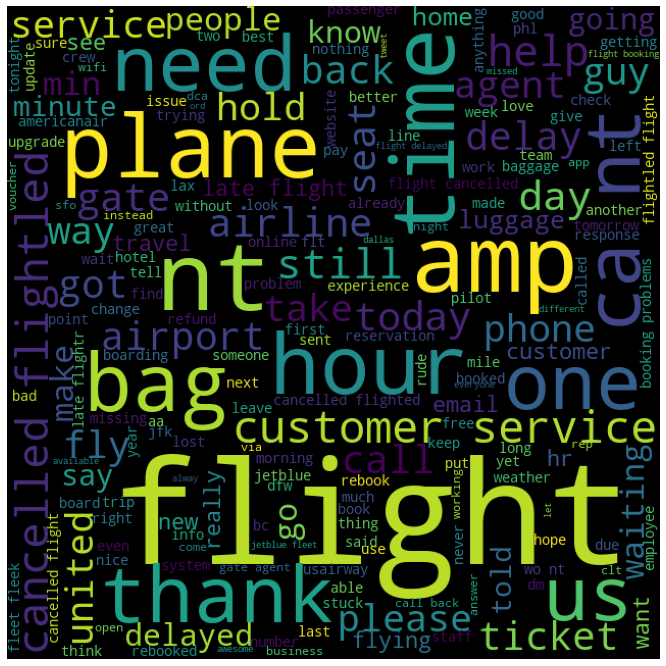

In [29]:
# Create the wordcloud object
wordcloud = WordCloud(width=640, height=640, margin=0).generate(final_cleaned_one_list_words)
 
# Display the generated image:
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

The most common words, is flight, customer service, thanks, hour plane, cancelled flight, which some of them are the reasons from the negativereasons columns.

# **Clustering**

We are going to see the twitter distribution, based on the Tf-idf and document similarity, so we will be extracting the features from the clean list generated in the previous section, and we will use the code in the notebook provided by the teacher. 

We need to change, the separate elements (words) into one element (one big sentence), so that we can use it in our clustering.

In [0]:
final_cleaned_words_list = []
for words_list in final_cleaned_words:
  str1 =' '.join(words_list)
  #print(type(str1))
  #print(str1)
  final_cleaned_words_list.append(str1)

In [31]:
print(final_cleaned_words_list[14639])

ppl need know many seats next flight plz put us standby people next flight


In [0]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [0]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [0]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for word in final_cleaned_words_list:
    allwords_stemmed = tokenize_and_stem(word)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(word)
    totalvocab_tokenized.extend(allwords_tokenized)


In [35]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 130693 items in vocab_frame


The vocac_frame is our voacabulary, how many words we have, full words and root words.

In [36]:
print(vocab_frame.head())

                words
dhepburn     dhepburn
said             said
plus             plus
ad              added
commerci  commercials


Feature extraction from the clean list. 

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer( max_features=20000, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(final_cleaned_words_list)

print(tfidf_matrix.shape)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


CPU times: user 4.89 s, sys: 25.3 ms, total: 4.91 s
Wall time: 4.94 s
(14640, 20000)


In [38]:
type(tfidf_matrix)

scipy.sparse.csr.csr_matrix

In [39]:
print(tfidf_matrix)

  (0, 15156)	1.0
  (1, 5308)	0.39681255008804656
  (1, 3284)	0.5832248267642824
  (1, 173)	0.5089450680386252
  (1, 13806)	0.4933188819187377
  (2, 1016)	0.632854904861383
  (2, 18064)	0.3453237195551094
  (2, 967)	0.3336170582176134
  (2, 11094)	0.27298289706689066
  (2, 10514)	0.40180937941337724
  (2, 17596)	0.30341711671786437
  (2, 11471)	0.2022707847880196
  (3, 862)	0.3650730323778505
  (3, 14524)	0.3384165302492584
  (3, 9910)	0.24505212246654737
  (3, 783)	0.16030247350481983
  (3, 5410)	0.28844974021754644
  (3, 7562)	0.32282347610363826
  (3, 5099)	0.2728566860719263
  (3, 11914)	0.3650730323778505
  (3, 1956)	0.3324883261965206
  (3, 319)	0.35400958439487845
  (3, 14337)	0.18822830549110536
  (4, 1507)	0.6180630849085306
  (4, 17226)	0.4020333680519095
  :	:
  (14638, 3287)	0.2869480244459744
  (14638, 6311)	0.23179513491263473
  (14638, 10948)	0.21446683375269807
  (14638, 2808)	0.21642293999404466
  (14638, 1028)	0.2401624738698124
  (14638, 2782)	0.15961570661921168
  (1

This shows how they are related, as we can see there some close relation, from the visualization words, there are not many different words, meaning that there are many repetitions like flight, cancelled,  and the names of the airlines.

In [0]:
terms = tfidf_vectorizer.get_feature_names()

In [41]:
print(terms[9000])

issu flight


In [0]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

I decided to have 3 cluster because I thought it would be convenient if could related the words that the cluster have classified with the sentiment related. 

In [43]:
from sklearn.cluster import KMeans

num_clusters = 3

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 43.6 s, sys: 17.3 s, total: 1min
Wall time: 40.2 s


In [44]:
from sklearn.externals import joblib

joblib.dump(km,  '/content/gdrive/My Drive/Colab Notebooks/LSMA/4 - Text_Analysis-1/doc_cluster_movie.pkl')
km = joblib.load('/content/gdrive/My Drive/Colab Notebooks/LSMA/4 - Text_Analysis-1/doc_cluster_movie.pkl')
clusters = km.labels_.tolist()

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [45]:
print(clusters)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 

In [46]:
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,airline,name,text
0,570306133677760513,neutral,1.0000,NaN,Virgin America,cairdin,@VirginAmerica What @dhepburn said.
1,570301130888122368,positive,0.3486,NaN,Virgin America,jnardino,@VirginAmerica plus you've added commercials t...
2,570301083672813571,neutral,0.6837,NaN,Virgin America,yvonnalynn,@VirginAmerica I didn't today... Must mean I n...
3,570301031407624196,negative,1.0000,Bad Flight,Virgin America,jnardino,@VirginAmerica it's really aggressive to blast...
4,570300817074462722,negative,1.0000,Can't Tell,Virgin America,jnardino,@VirginAmerica and it's a really big bad thing...


In [0]:
import pandas as pd

tweets_test = { 'tweet_id': tweets['tweet_id'],'sentiment_airline': tweets['airline_sentiment'], 'airline': tweets['airline'], 'neg_reason': tweets['negativereason'], 'cluster': clusters}
tweets_cluster = pd.DataFrame(tweets_test , columns = ['tweet_id','sentiment_airline', 'airline','neg_reason','cluster'])

In [48]:
tweets_cluster.head(10)

,tweet_id,sentiment_airline,airline,neg_reason,cluster
0,570306133677760513,neutral,Virgin America,NaN,1
1,570301130888122368,positive,Virgin America,NaN,1
2,570301083672813571,neutral,Virgin America,NaN,1
3,570301031407624196,negative,Virgin America,Bad Flight,1
4,570300817074462722,negative,Virgin America,Can't Tell,1
5,570300767074181121,negative,Virgin America,Can't Tell,1
6,570300616901320704,positive,Virgin America,NaN,1
7,570300248553349120,neutral,Virgin America,NaN,1
8,570299953286942721,positive,Virgin America,NaN,1
9,570295459631263746,positive,Virgin America,NaN,1


In [49]:
tweets_cluster['cluster'].value_counts()

1    13509
0      952
2      179
Name: cluster, dtype: int64

There is one cluster with many tweets, this could be considering the number of tweets, the cluster that contains the most negative words. 

In [50]:
from __future__ import print_function

print('Top terms per cluster:')
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print('Cluster %d words:' % i, end='')
    for ind in order_centroids[i, :6]:
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print()
  

Top terms per cluster:

Cluster 0 words: b'flight', b'cancelled', b'cancelled', b'flightled', b'cancelled', b'flight',
Cluster 1 words: b'flight', b'thanks', b'nt', b'http', b'hour', b'delayed',
Cluster 2 words: b'thanks', b'happened', b'usairways', b'right', b'thanks', b'flightled',


The cluster than contains more tweets is the one that shows the most frequent words as we've seen like service, thanks, customer and help, belonging to the negative reason customer service issues. 
The second largest cluster is the one that contains flight and cancelled, since it was the second used in the negative reason column. 


# **Text search engine**

First we will split our final_cleaned words into training and testing, so that we can have a set to test if our search engine is working properly.

In [51]:
print(final_cleaned_words_list[14639])

ppl need know many seats next flight plz put us standby people next flight


We are going to divide the cleaned_words, into a training and test test. In the training we will 80% of the total tweets. 

In [0]:
X_train = final_cleaned_words_list[0:11712]
X_test = final_cleaned_words_list[11712:14640]

In [53]:
type(X_train)

list

In [54]:
print(X_train[11711])

thanks


In [55]:
type(X_test)

list

In [56]:
print(X_test[14639])

IndexError: ignored

**Feature extraction**

Bag of Words: collection of words to represent a sentence with word count and mostly disregarding the order in which they appear

In [57]:
# Let's create our BoW model!
bow_model = CountVectorizer()
bow_model.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [58]:
tr_sample = 0
bow_features = bow_model.transform(X_train).todense()
print(bow_features.shape)

(11712, 11106)


In [59]:
print(bow_features)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


**Tf-idf**

Let's try to extract some text features such as the so-called Tf-idf. More specifically, Tf-idf stands for Term Frequency-Inverse Document Frequency. You can see The tf-idf as a weight often used in information retrieval and text mining. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus.

We have previously obtained this features vectors for the entire dataset, so now we are going to extract only for the X_train. 

In [60]:
max_features= 10000

# Build the model
tfidf_model = TfidfVectorizer(max_features=max_features)
tfidf_model

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=10000,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [61]:
# Transform the training data
tfidf_features = tfidf_model.fit_transform(X_train)
print("TF-idf Feature Shape: {}".format(tfidf_features.shape))

TF-idf Feature Shape: (11712, 10000)


In [62]:
print(tfidf_features)

  (0, 7169)	1.0
  (1, 8302)	0.5715438940423648
  (1, 3021)	0.3094542120335387
  (1, 1786)	0.4975401447897001
  (1, 112)	0.43264245034863763
  (1, 6258)	0.377955000385711
  (2, 8979)	0.3535051634181382
  (2, 408)	0.3448114326933544
  (2, 8316)	0.34346468960645293
  (2, 5575)	0.2988723510737459
  (2, 5404)	0.4418671949119929
  (2, 5550)	0.4614319646016521
  (2, 8814)	0.31013909097616604
  (2, 5661)	0.21093640849983714
  (3, 6671)	0.3457627827647354
  (3, 5247)	0.2536134245483525
  (3, 360)	0.16745908608749263
  (3, 3076)	0.36210879270324337
  (3, 3913)	0.35311293428150464
  (3, 2825)	0.28822969874292104
  (3, 5694)	0.3737064713231578
  (3, 940)	0.3737064713231578
  (3, 188)	0.36210879270324337
  (3, 6617)	0.19688085461121618
  (4, 8681)	0.5462542177075705
  :	:
  (11708, 6076)	0.21104636064336327
  (11708, 3176)	0.40364096566385793
  (11708, 9510)	0.2562088938277155
  (11708, 2062)	0.1833221964458195
  (11708, 9312)	0.35210811503607686
  (11708, 3686)	0.10998677473207372
  (11708, 1262)	

**Word2vec**

Its input consists in a raw text corpus whereas its output is a set of vectors that better represents the text input.

In [0]:
X_train_list = final_cleaned_words[0:11712]
X_test_list = final_cleaned_words[11712:14640]

In [64]:
min_count = 5
size = 100
iterations = 50
seed = 125
workers = 3
window = 5
filename = 'word2vec_newsgroups.bin'

# Build and training the model
w2v_model = Word2Vec(X_train_list, size=size, min_count=min_count, iter=iterations,
                 seed=seed, workers=workers, window=window)
# Save the model into a binary file
w2v_model.save(filename)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
w2v_model.init_sims(replace=True)

In [66]:
words = list(w2v_model.wv.vocab)
print(words)

['said', 'plus', 'added', 'commercials', 'experience', 'nt', 'today', 'must', 'mean', 'need', 'take', 'another', 'trip', 'really', 'entertainment', 'amp', 'little', 'recourse', 'big', 'bad', 'thing', 'seriously', 'would', 'pay', 'flight', 'seats', 'playing', 'flying', 'va', 'yes', 'nearly', 'every', 'time', 'fly', 'vx', 'go', 'away', 'missed', 'opportunity', 'without', 'https', 'well', 'amazing', 'arrived', 'hour', 'early', 'good', 'know', 'second', 'leading', 'cause', 'death', 'among', 'lt', 'pretty', 'much', 'better', 'great', 'deal', 'already', 'thinking', 'australia', 'even', 'gone', 'yet', 'p', 'fabulous', 'skies', 'u', 'stress', 'travel', 'http', 'thanks', 'schedule', 'still', 'mia', 'excited', 'first', 'cross', 'country', 'lax', 'mco', 'heard', 'nothing', 'things', 'virgin', 'america', 'flew', 'nyc', 'sfo', 'last', 'week', 'could', 'fully', 'sit', 'seat', 'due', 'two', 'large', 'either', 'side', 'help', 'virginamerica', 'awesome', 'please', 'want', 'fares', 'may', 'three', 'time

In [67]:
word2vec_features = w2v_model[w2v_model.wv.vocab]
word2vec_features.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


(2459, 100)

In [68]:
print(word2vec_features)

[[ 1.17784388e-01 -2.21098424e-04 -3.82735990e-02 ... -1.29214808e-01
  -1.26811028e-01  5.70871234e-02]
 [-2.23348662e-02 -1.02362111e-01  2.08612546e-01 ...  2.72059124e-02
   7.96180889e-02  8.89260843e-02]
 [ 3.83055285e-02  5.14505384e-03 -7.03848600e-02 ...  1.31172717e-01
  -6.57301471e-02  1.01407513e-01]
 ...
 [-1.10870570e-01  4.51559648e-02 -1.84580579e-01 ...  2.82129198e-01
  -5.86654134e-02 -2.09457297e-02]
 [-7.93302581e-02 -1.96504779e-02 -1.02428235e-01 ... -1.17940838e-02
   4.75101061e-02  1.84817493e-01]
 [-2.17329990e-02  8.37018043e-02  1.26530891e-02 ...  2.08016671e-02
   1.45307630e-01  7.53840134e-02]]


# **Text Engine**

In [0]:
"""
Main Functionalities for extracting features
"""           
def extract_w2v_tfidf_features(X, w2v_model, tfifd_model):
    X_features = np.array([])
    non_valid_idx = []
    data = X.data
    for i, s in enumerate(data):
        x = np.array(compute_w2v_tfidf(s, w2v_model, tfifd_model))
        if len(x.shape)>0:
            x = x[np.newaxis, :]
            if i == 0:
                X_features = x
            else:
                X_features = np.concatenate([X_features, x], axis=0)
        else:
            non_valid_idx.append(i)
    return X_features

def extract_w2v_average_features(X, w2v_model):
    # Extract the feature for training ...
    X_features = np.array([])
    non_valid_idx = []
    data = X.data
    for i, s in enumerate(data):
        x = np.array(compute_w2v_average(s, w2v_model))
        if len(x.shape)>0:
            x = x[np.newaxis, :]
            if i == 0:
                X_features = x
            else:
                X_features = np.concatenate([X_features, x], axis=0)
        else:
            non_valid_idx.append(i)
    return X_features

def get_X_features(model, X, bow_model, tfidf_model, w2v_model):
    """Calculate features for a given X input
    """
    x_features = None
    print("Extracting features using {} model".format(model.title()))
    if model == "tfidf":
        x_features = tfidf_model.transform(X)
    elif model == "bow":
        x_features = bow_model.transform(X)
    elif model == "w2v_tfidf":
        x_features = extract_w2v_tfidf_features(X, w2v_model, tfidf_model)
    else:
        x_features = extract_w2v_average_features(X, w2v_model, tfidf_model)
    return x_features

def plot_results(input_texts, D, N):
    """input, distance and neighboors results
    """
    for input_text, distances, neighbors in zip(input_texts, D, N):
        print("Input text = ", input_text[:200], "\n")
    for dist, neighbor_idx in zip(distances, neighbors):
        print("Distance = ", dist, "Neighbor idx = ", neighbor_idx)
        print(final_cleaned_words[neighbor_idx][:200])
        print("-"*200)
    print("="*200)
    print()

In [78]:
# You can select which features use from: "tfidf", "bow" or "w2v_tfidf"
model = "tfidf"
X_train_features = get_X_features(model=model, X=X_train, bow_model=bow_model,
                                  tfidf_model=tfidf_model, w2v_model=w2v_model)
X_test_features = get_X_features(model=model, X=X_test, bow_model=bow_model,
                                  tfidf_model=tfidf_model, w2v_model=w2v_model)

Extracting features using Tfidf model
Extracting features using Tfidf model


In [79]:
print(X_train_features.shape)
print(X_test_features.shape)

(11712, 10000)
(2928, 10000)


In [80]:
# Build a simple ML model to make the query search
knn = NearestNeighbors(n_neighbors=10, metric='cosine')
knn

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                 radius=1.0)

In [81]:
# Fit the model
knn.fit(X_train_features)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                 radius=1.0)

In [82]:
# Test a new sample
index_sample = random.sample([i for i in range(X_test_features.shape[0])], 1)[0]
input_test_sample = X_test[index_sample]

input_sample = X_test_features[index_sample, :]
if model == "w2v_tfidf":
    input_sample = input_sample.reshape(1, -1)
input_sample.shape

(1, 10000)

In [0]:
# Let's retrieve the results of the most similar neighboors as well as the distances!!
D, N = knn.kneighbors(input_sample, n_neighbors=5, return_distance=True)

In [84]:
plot_results([input_test_sample], D, N)

Input text =  cool weather delays etc lying deceiving passengers keep changing reprehensible yousuck 

Distance =  0.6960183532294386 Neighbor idx =  1125
['cool']
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Distance =  0.6960183532294386 Neighbor idx =  8465
['u', 'cool']
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Distance =  0.6996538508337018 Neighbor idx =  6066
['passengers', 'automatically', 'rebooked', 'flights', 'original', 'cancelled', 'flighted', 'weather', 'etc']
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Dista

## **Conclusions**

**Bow Model**


Input text =  disappointing lack kindness toward person agent asked counterparts person talking 

Distance =  0.6655031959971637 Neighbor idx =  1016
['thank', 'mention', 'boarded', 'asked', 'person', 'measure', 'bag', 'another', 'woman', 'men', 'asked']
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Distance =  0.6776708143898479 Neighbor idx =  9070
['beamske', 'real', 'live', 'person', 'talk', 'person', 'whose', 'luggage', 'lost', 'days', 'vacation', 'wrecked']
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Distance =  0.6984886554222364 Neighbor idx =  11555
['phone', 'talk', 'real', 'person']
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Distance =  0.6984886554222364 Neighbor idx =  7600
['thx', 'social', 'media', 'person']
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Distance =  0.7074910303491477 Neighbor idx =  3275
['maybe', 'person', 'working', 'customer', 'service', 'desk', 'houston', 'airport', 'line', 'rows', 'deep', 'person', 'working']



The input word had words like person and asked, which also appear in the queries, and similar words related to person, like men and woman, and related to asked, like talk

**Tf-id**


Input text =  ejacqui updated screens people would know late flightst info good bad would nt work 

Distance =  0.6110168434426916 Neighbor idx =  5677
['would']
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Distance =  0.7195616639134188 Neighbor idx =  920
['nt', 'work']
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Distance =  0.7230628089553572 Neighbor idx =  2008
['thanks', 'good', 'know']
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Distance =  0.724732935411257 Neighbor idx =  8749
['nt', 'know', 'one', 'would', 'tell', 'coming', 'would', 'guess', 'changes', 'flights']
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Distance =  0.7318186386115373 Neighbor idx =  4070
['leave', 'work', 'would', 'possible', 'would', 'love', 'replaced']
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
========================================================================================================================================================================================================


In this case, the output queries contained words that was in the nput text, like would, know, flights, work. 


## **Classifier**

We will try to classify our tweet according to its assign labelled.

In [100]:
tweets.loc[:,('airline_sentiment')] = tweets.airline_sentiment.map({'neutral':0, 'positive':1,'negative':2})
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,airline,name,text
0,570306133677760513,0,1.0000,NaN,Virgin America,cairdin,@VirginAmerica What @dhepburn said.
1,570301130888122368,1,0.3486,NaN,Virgin America,jnardino,@VirginAmerica plus you've added commercials t...
2,570301083672813571,0,0.6837,NaN,Virgin America,yvonnalynn,@VirginAmerica I didn't today... Must mean I n...
3,570301031407624196,2,1.0000,Bad Flight,Virgin America,jnardino,@VirginAmerica it's really aggressive to blast...
4,570300817074462722,2,1.0000,Can't Tell,Virgin America,jnardino,@VirginAmerica and it's a really big bad thing...


In [0]:
tweets['text']=final_cleaned_words_list

In [103]:
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,airline,name,text
0,570306133677760513,0,1.0000,NaN,Virgin America,cairdin,dhepburn said
1,570301130888122368,1,0.3486,NaN,Virgin America,jnardino,plus added commercials experience tacky
2,570301083672813571,0,0.6837,NaN,Virgin America,yvonnalynn,nt today must mean need take another trip
3,570301031407624196,2,1.0000,Bad Flight,Virgin America,jnardino,really aggressive blast obnoxious entertainmen...
4,570300817074462722,2,1.0000,Can't Tell,Virgin America,jnardino,really big bad thing


In [0]:
from sklearn.model_selection import train_test_split


X_train,X_test,y_train,y_test = train_test_split(tweets["text"],tweets["airline_sentiment"], test_size = 0.2, random_state = 10)
vect = CountVectorizer()
vect.fit(X_train)
X_train_df = vect.transform(X_train)
X_test_df = vect.transform(X_test)

In [0]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train_df,y_train)
result=clf.predict(X_test_df)

In [109]:
print(result)

[2 1 2 ... 2 2 2]


In [107]:
print("Accuracy Score:",accuracy_score(y_test,result))

Accuracy Score: 0.773224043715847


We could try other classifiers and compare performance and select which is better, but I had no time to do it.

## **Conclusions**

---



---



I found this lab really usefull, as it has helped me in my final project, and text cleaning is not something that I have thought thoroughly. 

I had some problems in the type of variable that I was using, and what kind was the function that I was going to use expecting, so I had to print every time the type. H
